In [2]:
import jupyter

In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 10_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [4]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [5]:
def add_lags(df,lags):
   
    df_lag = df.copy()
    for lag in range(1, lags + 1):
     
        df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag[f'volume_lag_{lag}'] = df_lag['volume_change'].shift(lag)
        df_lag[f'market_return_lag_{lag}'] = df_lag['market_return_1d'].shift(lag)
   
    #df_lag = df_lag.dropna()
    #print(df_lag)
    return df_lag


In [6]:
def residual_based_predictability_label(df_lag, run_settings):
    """
    Estimate predictability (cv_r2) using residuals from RandomForestRegressor.
    Supports sub-episode curriculum-style partitions.
    """
    required_cols = (
        [f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)] +
        [f'volume_lag_{i}' for i in range(1, run_settings['lags'] + 1)] +
        [f'market_return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]
    )

    df_lag = df_lag.dropna(subset=required_cols + ['return_1d'])

    if len(df_lag) < run_settings["min_samples"]:
        return np.nan  # Not enough data

    X = df_lag[required_cols].values
    y = df_lag['return_1d'].values

    splits = [1/3, 2/3, 1.0]
    cv_r2s = []

    for split in splits:
        split_len = int(len(X) * split)
        if split_len < run_settings["min_samples"]:
            continue  # Avoid underfitting
        X_split = X[:split_len]
        y_split = y[:split_len]

        model = RandomForestRegressor(
            n_estimators=config['n_estimators'],
            random_state=config['random_state']
        )
        model.fit(X_split, y_split)
        r2 = np.mean(cross_val_score(model, X_split, y_split, cv=run_settings["cv_folds"], scoring='r2'))
        cv_r2s.append(r2)

    # You could return just the final r² or an average across splits
    final_r2 = np.mean(cv_r2s) if cv_r2s else np.nan
    return final_r2


In [ ]:
def extract_agent_residual_diagnostics(env, model, episode_id, total_timesteps):
    """
    Runs agent through environment and extracts residual diagnostics from reward trajectory.
    """
    rewards = []
    residuals = []
    predicted_scores = []

    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)

        # Optional: if info contains oracle reward, use it to calculate residual
        oracle_reward = info.get("oracle_score", None)  # custom if available
        if oracle_reward is not None:
            residuals.append(oracle_reward - reward)
        else:
            predicted_scores.append(reward)  # fallback

    # Use residuals if available, otherwise use deviations from mean reward
    if residuals:
        r = np.array(residuals)
    else:
        # Residual = reward - smoothed expected value
        smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
        r = np.array(rewards) - smoothed.values

    # Diagnostics
    diagnostics = {
        'episode_id': episode_id,
        'total_timesteps': total_timesteps,
        'resid_std': np.std(r),
        'resid_skew': skew(r),
        'resid_kurtosis': kurtosis(r),
        'resid_acf1': pd.Series(r).autocorr(lag=1),
        'ljung_pval': acorr_ljungbox(r, lags=[min(10, len(r)-1)], return_df=True).iloc[0]['lb_pvalue'] if len(r) > 10 else np.nan,
        'resid_mean': np.mean(r),
        'resid_max': np.max(r),
        'resid_min': np.min(r),
    }

    return diagnostics

In [7]:
# Feature Extraction Loop ====================
features, targets, metadata = [], [], []
def central_tendency_difference (mean,median):
    return abs(mean-median)/(abs(mean+median)/2)

for symbol in tqdm(tickers):
    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df = df[df['date'] > run_settings['start_date']]
    df = df.iloc[:-run_settings["episode_length"]]
    months = df['month'].unique()
    # t stands for time
    # t1_ stands for time+1
    for i in range(len(months)):
        try:
            
            target_date = str(months[i])+'-01' 
            episodes = ep_tracker.findEpisode(
                target_date,
                symbol,
                episode_length=run_settings['episode_length'],
                lookback=run_settings['lookback'],
                mode='both')
            
            df_t0 = episodes['train']['df']
            df_t0 = add_lags(df_t0,run_settings["lags"])
            df_t0 = df_t0.iloc[episodes['train']['df_start_iloc']:]
            df_t1 = episodes['test']['df']
            df_t1 = add_lags(df_t1,run_settings["lags"])
        
            df_t1 = df_t1.iloc[episodes['test']['df_start_iloc']:]
          
            r1d = df_t0['return_1d'].astype(float).values
            v   = df_t0['volume_change'].astype(float).values
       
            feat = {
                'symbol': symbol,
                'target_date': target_date,
                'episode_id': episodes['train']['episode_id'],
                'next_episode_id': episodes['test']['episode_id'],
                #'month_str': str(m_t),
                
                'r1d_mean': np.mean(r1d),
                'r1d_median':np.median(r1d),
                'r1d_std': np.std(r1d),
                'r1d_ctm_diff': central_tendency_difference(np.mean(r1d),np.median(r1d)),
                'r1d_skew': skew(r1d),
                'r1d_kurtosis': kurtosis(r1d),
                'r1d_entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
                
                'v1d_mean': np.mean(v),
                'v1d_median':np.median(v),
                'v1d_std': np.std(v),
                'v1d_ctm_diff': central_tendency_difference(np.mean(v),np.median(v)),
                'v1d_skew': skew(v),
                'v1d_kurtosis': kurtosis(v),
                'v1d_entropy': entropy(np.histogram(v, bins=10, density=True)[0] + 1e-8),
            }
            
            #cv_r2 = residual_based_predictability_label(df_t1, run_settings)
            #print('cv',cv_r2)
            if cv_r2 is None:
                continue  # skip if label couldn't be computed

            features.append(feat)
            targets.append(cv_r2)
            metadata.append({
                "symbol": symbol,
                "target_date": target_date,
                "train_episode_id": episodes['train']['episode_id'],
                "test_episode_id": episodes['test']['episode_id']
            })

        except Exception as e:
            print(f"Skipping {symbol} {months[i]} due to error: {e}")
        except :
            print(months[i])
            


  0%|          | 0/1 [00:00<?, ?it/s]

cv -0.487182152831845
cv -0.862697402174927
cv -0.3703361007684695
cv -0.5245104572918781
cv -0.4595661218398064
cv -1.2694711961593261
cv -1.3578187158284336
cv -1.323281024665671
cv -0.6033362968009569
cv -0.415038400766567
cv -0.4884171163617524
cv -1.1755689485905938
cv -0.5507749794672885
cv -1.5651485177786648


100%|██████████| 1/1 [01:16<00:00, 76.91s/it]

cv -0.8128166327754655


In [8]:
# VISUAÇ INSPECTION =====================

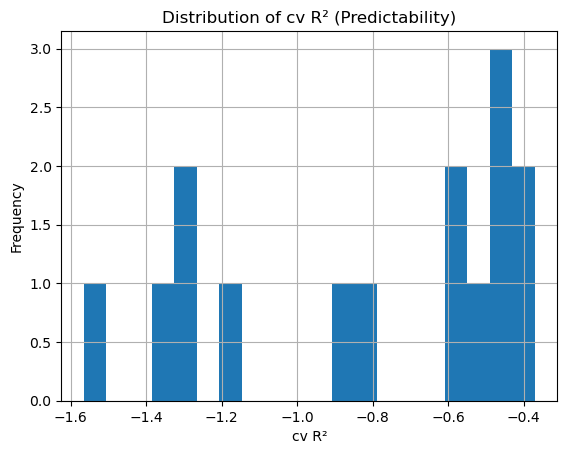

In [9]:
import pandas as pd

X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name="cv_r2")
meta_df = pd.DataFrame(metadata)
full_df = pd.concat([X_df, y_df, meta_df], axis=1)

import matplotlib.pyplot as plt

plt.hist(y_df, bins=20)
plt.title("Distribution of cv R² (Predictability)")
plt.xlabel("cv R²")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
print(full_df['cv_r2'].describe())
print(full_df['cv_r2'].head(10))

count       0
unique      0
top       NaN
freq      NaN
Name: cv_r2, dtype: object
Series([], Name: cv_r2, dtype: object)


In [24]:
ep_tracker = EpisodeTracker(df=OHLCV_DF)
ep= ep_tracker.findEpisode("2024-01-01",'AAPL',episode_length=120,mode="both")

env_tracker = EnvironmentTracker()

env_config = {
    "ticker": "AAPL",
    "n_timesteps": 120,
    "lookback": 0,
    "market_features": ["close","price_change", "volume_change"],
    #"full_df": "excluded",  # this will be ignored in hashing
    "seed": 314,
    "start_idx":ep['train']['df_start_iloc']
}

env_info = env_tracker.findEnvironment(version="v2", config=env_config)
train_env = env_info['environment']
env_config["start_idx"]=ep['test']['df_start_iloc']
test_env = env_tracker.findEnvironment(version="v2", config=env_config)
test_env = test_env['environment']


tracker = AgentTracker()
agent = tracker.findAgent(
    model_class="A2C",
    policy_class="MlpPolicy",
    config={ "verbose":1,"policy_kwargs": {"net_arch": [64, 64]}},
    #name="ppo_mlp_baseline"
)
_model = agent['model'].boot(train_env)
_model.learn(total_timesteps=50_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.189   |
| time/                 |          |
|    fps                | 283      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.689   |
|    explained_variance | 0.541    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0607  |
|    value_loss         | 0.0108   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.386   |
| time/                 |          |
|    fps                | 305      |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.311   |
| time/                 |          |
|    fps                | 302      |
|    iterations         | 1400     |
|    time_elapsed       | 23       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -0.689   |
|    explained_variance | -0.386   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -0.00737 |
|    value_loss         | 0.000403 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.3     |
| time/                 |          |
|    fps                | 306      |
|    iterations         | 1500     |
|    time_elapsed       | 24       |
|    total_timesteps    | 7500     |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.251   |
| time/                 |          |
|    fps                | 322      |
|    iterations         | 2700     |
|    time_elapsed       | 41       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | -0.00605 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.0396  |
|    value_loss         | 0.00297  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.247   |
| time/                 |          |
|    fps                | 324      |
|    iterations         | 2800     |
|    time_elapsed       | 43       |
|    total_timesteps    | 14000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.164   |
| time/                 |          |
|    fps                | 328      |
|    iterations         | 4000     |
|    time_elapsed       | 60       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0.107    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 0.0474   |
|    value_loss         | 0.0104   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.162   |
| time/                 |          |
|    fps                | 328      |
|    iterations         | 4100     |
|    time_elapsed       | 62       |
|    total_timesteps    | 20500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.133   |
| time/                 |          |
|    fps                | 323      |
|    iterations         | 5300     |
|    time_elapsed       | 81       |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 5.02e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | -0.0372  |
|    value_loss         | 0.00357  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.127   |
| time/                 |          |
|    fps                | 322      |
|    iterations         | 5400     |
|    time_elapsed       | 83       |
|    total_timesteps    | 27000    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.144   |
| time/                 |          |
|    fps                | 313      |
|    iterations         | 6700     |
|    time_elapsed       | 106      |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 6699     |
|    policy_loss        | -0.0297  |
|    value_loss         | 0.00213  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 119       |
|    ep_rew_mean        | -0.149    |
| time/                 |           |
|    fps                | 314       |
|    iterations         | 6800      |
|    time_elapsed       | 108       |
|    total_timesteps    | 34000     |
| train/                |    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.12    |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 8000     |
|    time_elapsed       | 126      |
|    total_timesteps    | 40000    |
| train/                |          |
|    entropy_loss       | -0.685   |
|    explained_variance | -0.014   |
|    learning_rate      | 0.0007   |
|    n_updates          | 7999     |
|    policy_loss        | -0.00256 |
|    value_loss         | 3.76e-05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.118   |
| time/                 |          |
|    fps                | 317      |
|    iterations         | 8100     |
|    time_elapsed       | 127      |
|    total_timesteps    | 40500    |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.106   |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 9300     |
|    time_elapsed       | 147      |
|    total_timesteps    | 46500    |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9299     |
|    policy_loss        | -0.00754 |
|    value_loss         | 0.000312 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 119      |
|    ep_rew_mean        | -0.102   |
| time/                 |          |
|    fps                | 315      |
|    iterations         | 9400     |
|    time_elapsed       | 149      |
|    total_timesteps    | 47000    |
| train/                |          |
|

In [28]:
def extract_agent_residual_diagnostics(env, model, episode_id, total_timesteps):
    """
    Runs agent through environment and extracts residual diagnostics from reward trajectory.
    """
    rewards = []
    residuals = []
    predicted_scores = []

    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)

        # Optional: if info contains oracle reward, use it to calculate residual
        oracle_reward = info.get("oracle_score", None)  # custom if available
        if oracle_reward is not None:
            residuals.append(oracle_reward - reward)
        else:
            predicted_scores.append(reward)  # fallback

    # Use residuals if available, otherwise use deviations from mean reward
    if residuals:
        r = np.array(residuals)
    else:
        # Residual = reward - smoothed expected value
        smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
        r = np.array(rewards) - smoothed.values

    # Diagnostics
    diagnostics = {
        'episode_id': episode_id,
        'total_timesteps': total_timesteps,
        'resid_std': np.std(r),
        'resid_skew': skew(r),
        'resid_kurtosis': kurtosis(r),
        'resid_acf1': pd.Series(r).autocorr(lag=1),
        'ljung_pval': acorr_ljungbox(r, lags=[min(10, len(r)-1)], return_df=True).iloc[0]['lb_pvalue'] if len(r) > 10 else np.nan,
        'resid_mean': np.mean(r),
        'resid_max': np.max(r),
        'resid_min': np.min(r),
    }

    return diagnostics

In [29]:
extract_agent_residual_diagnostics(test_env, _model,1,50_000)

{'episode_id': 1,
 'total_timesteps': 50000,
 'resid_std': 0.0364690873328135,
 'resid_skew': 4.276005868897345,
 'resid_kurtosis': 31.174463314941512,
 'resid_acf1': 0.031717621329648275,
 'ljung_pval': 0.5387166400137615,
 'resid_mean': -8.633245489910524e-05,
 'resid_max': 0.2840694789535254,
 'resid_min': -0.08502362666626283}

<Axes: >

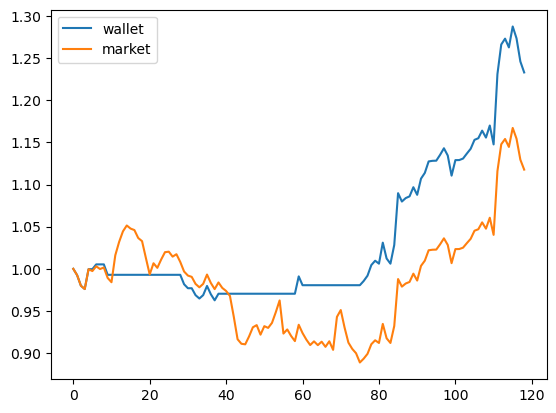

In [30]:
pd.DataFrame({"wallet":test_env.wallet_progress,"market":test_env.market_progress}).plot()

In [31]:
pd.DataFrame({"wallet":train_env.wallet_progress,"market":test_env.market_progress}).plot()

ValueError: All arrays must be of the same length

In [12]:
extract_agent_residual_diagnostics(test_env, _model,1,50_000)

{'episode_id': 1,
 'total_timesteps': 50000,
 'resid_std': 0.036701903131778846,
 'resid_skew': 4.2300851970260585,
 'resid_kurtosis': 30.34202220898235,
 'resid_acf1': 0.03284552725723159,
 'ljung_pval': 0.39781107427318235,
 'resid_mean': -8.633245489910851e-05,
 'resid_max': 0.2840694789535254,
 'resid_min': -0.08502362666626283}

<Axes: >

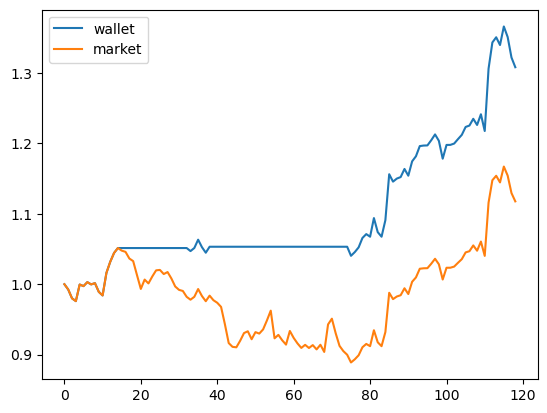

In [17]:
pd.DataFrame({"wallet":test_env.wallet_progress,"market":test_env.market_progress}).plot()

| Metric           | Value    | Visual Match / Interpretation                                        |
| ---------------- | -------- | -------------------------------------------------------------------- |
| `resid_std`      | `0.0367` | ✅ Stable across most steps — no huge swings until later              |
| `resid_skew`     | `4.23`   | 🔥 The *big gains* late in the episode cause the **positive tail**   |
| `resid_kurtosis` | `30.34`  | 💥 Those late sharp jumps are **rare** and **extreme outliers**      |
| `resid_acf1`     | `0.03`   | 🧘 Almost no autocorrelated error — agent is not trapped in patterns |
| `ljung_pval`     | `0.39`   | ✅ Residuals pass autocorrelation test — good generalization          |
| `resid_mean`     | ≈ `0`    | ✅ Unbiased — no systemic overshooting or undershooting               |
| `resid_max`      | `0.284`  | 🚀 The spike near the end — massive outperformance of expected       |
| `resid_min`      | `−0.085` | ⚠️ Small dip somewhere in the midsection — tolerable                 |


In [23]:
#train_env.episode_df

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,trade_count_change,sector_id,industry_id,return_1d,vix,vix_norm,sp500,sp500_norm,market_return_1d,month
0,33803,AAPL,2023-07-11 04:00:00,2023-07-11,189.16,189.3000,186.60,188.08,46646096.0,577864.0,...,-0.215898,10.0,unknown,-0.002810,0.1484,-0.015262,44.3926,0.006742,0.006742,2023-07
1,33804,AAPL,2023-07-12 04:00:00,2023-07-12,189.68,191.7000,188.47,189.77,60757160.0,652270.0,...,0.128760,10.0,unknown,0.008986,0.1354,-0.087601,44.7216,0.007411,0.007411,2023-07
2,33805,AAPL,2023-07-13 04:00:00,2023-07-13,190.50,191.1900,189.78,190.54,41348909.0,468081.0,...,-0.282382,10.0,unknown,0.004058,0.1361,0.005170,45.1004,0.008470,0.008470,2023-07
3,33806,AAPL,2023-07-14 04:00:00,2023-07-14,190.23,191.1799,189.63,190.69,41622330.0,513236.0,...,0.096468,10.0,unknown,0.000787,0.1334,-0.019838,45.0542,-0.001024,-0.001024,2023-07
4,33807,AAPL,2023-07-17 04:00:00,2023-07-17,191.90,194.3200,191.81,193.99,50546738.0,603051.0,...,0.174997,10.0,unknown,0.017306,0.1348,0.010495,45.2279,0.003855,0.003855,2023-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,33918,AAPL,2023-12-21 05:00:00,2023-12-21,196.10,197.0800,193.50,194.68,46485784.0,554963.0,...,0.007741,10.0,unknown,-0.000770,0.1365,-0.001463,47.4675,0.010301,0.010301,2023-12
116,33919,AAPL,2023-12-22 05:00:00,2023-12-22,195.18,195.4100,192.97,193.60,37149570.0,500544.0,...,-0.098059,10.0,unknown,-0.005548,0.1303,-0.045421,47.5463,0.001660,0.001660,2023-12
117,33920,AAPL,2023-12-26 05:00:00,2023-12-26,193.61,193.8900,192.83,193.05,28921648.0,488340.0,...,-0.024381,10.0,unknown,-0.002841,0.1299,-0.003070,47.7475,0.004232,0.004232,2023-12
118,33921,AAPL,2023-12-27 05:00:00,2023-12-27,192.49,193.5000,191.09,193.15,48092035.0,548205.0,...,0.122589,10.0,unknown,0.000518,0.1243,-0.043110,47.8158,0.001430,0.001430,2023-12


In [13]:
cccccccccccccccc

NameError: name 'cccccccccccccccc' is not defined

In [13]:
X = df_t1[
        [f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]+
        [f'volume_lag_{i}' for i in range(1, run_settings['lags'] + 1)]+
        [f'market_return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]
    ].values
X.shape[:10]

(50, 15)

In [ ]:
# episode_benchmarking_engine.py

import os
import json
import hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from typing import Optional, Dict, List
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.monitor import Monitor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from environments import PositionTradingEnv,PositionTradingEnvV1,PositionTradingEnvV2

# Updated utility functions

def generate_lagged_features(df, config):
    df = df.copy()
    if config.get('return'):
        df['return_1d'] = df['close'].pct_change()
    if config.get('volume'):
        df['volume_1d'] = df['volume'].pct_change()
    for lag in range(1, config.get('lags', 0) + 1):
        df[f'return_lag_{lag}'] = df['return_1d'].shift(lag)
        df[f'volume_lag_{lag}'] = df['volume_1d'].shift(lag)
    return df.dropna()

def compute_sharpe_ratio(returns):
    mean = np.mean(returns)
    std = np.std(returns)
    return mean / std if std > 0 else np.nan

def compute_sortino_ratio(returns):
    mean = np.mean(returns)
    downside_std = np.std(returns[returns < 0])
    return mean / downside_std if downside_std > 0 else np.nan

def compute_calmar_ratio(returns):
    cum_returns = np.cumprod(1 + returns)
    drawdown = np.max(cum_returns) - np.min(cum_returns)
    mean_return = np.mean(returns)
    return mean_return / drawdown if drawdown > 0 else np.nan



# Utility functions with real logic for agent and oracle evaluation
def compute_agent_metrics(model, env, random=False):
    obs, _ = env.reset()
    done, actions, values = False, [], []
    while not done:
        action = env.action_space.sample() if random else model.predict(obs, deterministic=True)[0]
        obs, reward, done, _, info = env.step(action)
        actions.append(action)

    values = np.array(env.env.wallet_progress)
    if len(values) < 2:
        return {}
   
    returns = values-1 #np.diff(values) #/ (values[:-1] + 1e-9)
    negative_returns = returns[returns < 0] if len(returns[returns < 0]) > 0 else np.array([1e-9])
    action_probs = np.bincount(actions, minlength=2) / (len(actions) + 1e-9)
    drawdowns = values / np.maximum.accumulate(values)
    max_drawdown = drawdowns.min() - 1 if len(drawdowns) > 0 else -1
    success_trades = env.env.success_trades = 0
    failed_trades = env.env.failed_trades = 0
    total_trades = env.env.total_trades = 0
  
    sharpe = 0
    sortino = 0
    calmar = 0
    if returns.std() !=0:
        sharpe = returns.mean() / (returns.std() + 1e-9) * np.sqrt(252)
        sortino = returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252)
   
    return {
        "reward": env.env.total_reward,
        "volatility": returns.std(),
        "entropy": -np.sum(action_probs * np.log2(action_probs + 1e-9)),
        "max_drawdown": max_drawdown,
        "sharpe": sharpe, #returns.mean() / (returns.std() + 1e-9) * np.sqrt(252),
        "sortino": sortino, #returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252),
        "calmar": returns.mean() / abs(max_drawdown + 1e-9),
        "success_trades": success_trades,
        "action_hold_ratio": np.mean(np.array(actions) == 0),
        "action_long_ratio": np.mean(np.array(actions) == 1),
        "cumulative_return": values[-1] / values[0] - 1 if values[0] != 0 else 0
    }

def compute_oracle_metrics(env):
    obs, _ = env.reset()
    done, actions, values = False, [], []
    

    while not done:
        curr_idx = env.env.step_idx
        next_idx = min(curr_idx + 1, len(env.env.prices) - 1)
        curr_price = env.env.prices[curr_idx]
        next_price = env.env.prices[next_idx]
        price_diff = next_price - curr_price
        action = 1 if price_diff > 0 else 0
        #action = episode_df.iloc[env.current]  # oracle always assumes uptrend (long)
        obs, reward, done, _, info = env.step(action)
        actions.append(action)

    values = np.array(env.env.wallet_progress)
    if len(values) < 2:
        return {}
    #print(values,actions)
    returns = values #np.diff(values) / (values[:-1] + 1e-9)
    negative_returns = returns[returns < 1] if len(returns[returns < 1]) > 0 else np.array([1e-9])
    action_probs = np.bincount(actions, minlength=2) / (len(actions) + 1e-9)
    drawdowns = values / np.maximum.accumulate(values)
    max_drawdown = drawdowns.min() - 1 if len(drawdowns) > 0 else -1

    success_trades = 0
    fail_trades = 0
    total_trades = 0
  

    return {
        "oracle_volatility": returns.std(),
        "oracle_entropy": -np.sum(action_probs * np.log2(action_probs + 1e-9)),
        "oracle_max_drawdown": max_drawdown,
        "oracle_sharpe": returns.mean() / (returns.std() + 1e-9) * np.sqrt(252),
        "oracle_sortino": returns.mean() / (negative_returns.std() + 1e-9) * np.sqrt(252),
        "oracle_calmar": returns.mean() / abs(max_drawdown + 1e-9),
        "oracle_success_trades": success_trades,
        "oracle_action_hold_ratio": np.mean(np.array(actions) == 0),
        "oracle_action_long_ratio": np.mean(np.array(actions) == 1),
        "oracle_cumulative_return": values[-1] / values[0] - 1 if values[0] != 0 else 0
    }



def compute_additional_diagnostics(env):
    df = env.env.episode_df
    df = generate_lagged_features(df.copy(), {'return': True, 'volume':True,'lags': 5})
    df = df.dropna()
    X = df[[f'return_lag_{i}' for i in range(1, 6)]].values
    y = df['return_1d'].values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    residuals = y - model.predict(X)
    ljung_pval = acorr_ljungbox(residuals, lags=[5], return_df=True).iloc[0]['lb_pvalue']
    return {
        'resid_std': residuals.std(),
        'resid_skew': skew(residuals),
        'resid_kurtosis': kurtosis(residuals),
        'ljung_pval': ljung_pval
    }

class EpisodeBenchmarkingEngine:
    def __init__(self, 
                 df: pd.DataFrame,
                 experiment_name: str= "episode_benchmark_engine",
                 agent_classes: List = [PPO, A2C],
                 seeds: List[int] = RANDOM_SEEDS,
                 train_steps: List[int] = [200_000], #, 50_000, 100_000, 200_000],
                 n_timesteps: int = 120,
                 lookback: int = 0,
                 min_valid_length: int = 100,
                 market_features=['close','volume'],
                 feature_config: Dict = None,
                ):

        self.df = df.copy()
        self.experiment_name = experiment_name
        self.agent_classes = agent_classes
        self.seeds = seeds
        self.train_steps = train_steps
        self.n_timesteps = n_timesteps
        self.lookback = lookback
        self.min_valid_length = min_valid_length
        self.market_features = market_features
        self.feature_config = feature_config or {'return': True, 'volume': True, 'lags': 5}
        self.envs = [PositionTradingEnv,PositionTradingEnvV1,PositionTradingEnvV2]
        self.base_path = f"data/experiments/{experiment_name}"
        self.checkpoint_path = os.path.join(self.base_path, "checkpoints")
        self.result_path = os.path.join(self.base_path, "meta_df_transfer.csv")
        os.makedirs(self.checkpoint_path, exist_ok=True)

    def _get_config_hash(self, config: Dict) -> str:
        raw = json.dumps(config, sort_keys=True)
        return hashlib.sha256(raw.encode()).hexdigest()

    def _save_model(self, model, config_hash, agent_name, seed):
        model_path = os.path.join(self.checkpoint_path, f"{agent_name}_{config_hash}_{seed}.zip")
        model.save(model_path)

    def _load_seen_hashes(self) -> set:
        if os.path.exists(self.result_path):
            df = pd.read_csv(self.result_path)
            return set(zip(df['config_hash'], df['agent_name'], df['seed']))
        return set()

    def train(self, ticker: str):
        df_ticker = self.df[self.df['symbol'] == ticker].sort_values("date").reset_index(drop=True)
        months = df_ticker['date'].dt.to_period("M").unique()[24:]

        records = []
        seen_hashes = self._load_seen_hashes()
        market_features = self.market_features
        #for m in tqdm(months[1:-1], desc=f"Benchmarking {ticker}"):
        for m in tqdm(months[1:2], desc=f"Benchmarking {ticker}"):
            train_end_date = pd.Timestamp(m.start_time)
            train_start_idx = df_ticker[df_ticker['date'] < train_end_date].index.max() - self.n_timesteps
            test_start_idx = df_ticker[df_ticker['date'] < train_end_date].index.max() - self.lookback

            if train_start_idx - self.lookback < 0 or test_start_idx + self.n_timesteps >= len(df_ticker):
                continue
            _df = df_ticker.copy() #.iloc[train_start_idx - self.lookback: train_start_idx + self.n_timesteps].copy()
            #df_train = df_ticker.iloc[train_start_idx - self.lookback: train_start_idx + self.n_timesteps].copy()
            #df_test = df_ticker.iloc[test_start_idx - self.lookback: test_start_idx + self.n_timesteps].copy()

            #df_train = generate_lagged_features(df_train, self.feature_config)
            #df_test = generate_lagged_features(df_test, self.feature_config)
            _df = generate_lagged_features(_df, self.feature_config)
            df_train = _df.iloc[: train_start_idx + self.n_timesteps].copy()
            df_test = _df.iloc[: test_start_idx + self.n_timesteps].copy()
            for agent_cls in self.agent_classes:
                for seed in self.seeds:
                    for steps in self.train_steps:
                        for env_cls in self.envs:
                            print(train_start_idx)
                            env_version = 'v'+str(env_cls.__version__)
                            config = {
                                'ticker': ticker,
                                'train_idx': int(train_start_idx),
                                'test_idx': int(test_start_idx),
                                'agent_policy':'MlpPolicy',
                                'agent_name': agent_cls.__name__,
                                'env_version':env_version,
                                'agent_args':json.dumps({"ent_coef":0.1}),
                                'timesteps': steps,
                                'seed': seed,
                                'feature_config': self.feature_config,
                                'market_features':json.dumps(market_features)
                            }
                            config_hash = self._get_config_hash(config)

                            if (config_hash, agent_cls.__name__, seed) in seen_hashes:
                                continue

                            env_train = Monitor(PositionTradingEnv(df_train, ticker , market_features=market_features, n_timesteps=self.n_timesteps, seed=seed, start_idx=train_start_idx))
                            model = agent_cls("MlpPolicy", env_train, verbose=0, seed=seed, ent_coef=0.1)
                            model.learn(total_timesteps=steps)
                            self._save_model(model, config_hash, agent_cls.__name__, seed)

                            train_metrics = compute_agent_metrics(model, env_train)
                            rand_metrics = compute_agent_metrics(None, env_train, random=True)

                            env_test = Monitor(PositionTradingEnv(df_test, ticker,market_features=market_features, n_timesteps=self.n_timesteps, seed=seed, start_idx=test_start_idx))
                            test_metrics = compute_agent_metrics(model, env_test)
                            rand_test_metrics = compute_agent_metrics(None, env_test, random=True)

                            oracle_train = compute_oracle_metrics(env_train)
                            oracle_test = compute_oracle_metrics(env_test)

                            record = {
                                'ticker': ticker,
                                'config_hash': config_hash,
                                'agent_name': agent_cls.__name__,
                                'env_version':env_version,
                                'seed': seed,
                                'month': m,
                                #'train_reward': train_metrics['reward'],
                                #'test_reward': test_metrics['reward'],
                                #'train_random': rand_metrics['reward'],
                                #'test_random': rand_test_metrics['reward'],
                                'advantage_train': train_metrics['reward'] - rand_metrics['reward'],
                                'advantage_test': test_metrics['reward'] - rand_test_metrics['reward'],
                                'transfer_advantage': test_metrics['reward'] - rand_test_metrics['reward'],
                                'generalization_score': (test_metrics['reward'] / (oracle_test.get("oracle_cumulative_return", 1e-9))) -
                                                        (rand_test_metrics['reward'] / (oracle_test.get("oracle_cumulative_return", 1e-9))),
                                'market_features':json.dumps(market_features),
                                **{f"train_{k}": v for k, v in train_metrics.items()},
                                **{f"test_{k}": v for k, v in test_metrics.items()},
                                **{f"train_random_{k}": v for k, v in rand_metrics.items()},
                                **{f"test_random_{k}": v for k, v in rand_test_metrics.items()},
                                **{f"train_{k}": v for k, v in oracle_train.items()},
                                **{f"test_{k}": v for k, v in oracle_test.items()},
                                #**oracle_train,
                                #**oracle_test,
                                #**test_metrics,
                                **compute_additional_diagnostics(env_test)
                            }
                            print(env_version,record['train_action_hold_ratio'],record['train_oracle_action_hold_ratio'])
                            records.append(record)

                if records:
                    df_new = pd.DataFrame(records)
                    if os.path.exists(self.result_path):
                        df_existing = pd.read_csv(self.result_path)
                        df_all = pd.concat([df_existing, df_new], ignore_index=True)
                    else:
                        df_all = df_new
                    df_all.to_csv(self.result_path, index=False)
                    print(f"[✓] Results saved to {self.result_path}")

    def evaluate(self):
        df = pd.read_csv(self.result_path)
        print("[INFO] Transfer success rate:", (df['transfer_delta'] > 0).mean())
        plt.hist(df['transfer_delta'], bins=50)
        plt.title("Transfer Delta Distribution")
        plt.show()
        return df

    def predict(self):
        print("[TODO] Implement meta-feature-based predictor")

    def report(self):
        print("[TODO] Implement full report generation with diagnostics")


In [ ]:
ebm = EpisodeBenchmarkingEngine(OHLCV_DF)

In [ ]:
ebm.train('AAPL')